In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
%matplotlib inline

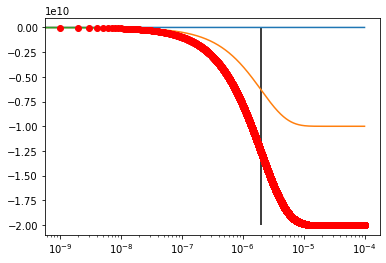

In [2]:
def vt_const(P,t,effic, jE,relaxTime):
    #effic = 0.85 #Function of E/N, but const for now
    #jE = 1e13 #Assumed to be constant too
    #relaxTime = 20e-6
    
    rhs = -(effic*jE)/relaxTime - P/relaxTime
    
    return rhs

t = np.linspace(0, 100e-6, 100000)
P0 = 0.0
effic = 0.65
jE = 1e11 #Constant value assumption
relaxTime = 2e-6 #The solution is inversely proportional to this value
for i in range(3):  
    P_vt = odeint(vt_const, P0, t, args=(0.1*i, jE, relaxTime))
    plt.plot(t,P_vt)
plt.vlines(relaxTime, np.min(P_vt),0)
plt.plot(t, 0.1*i*jE*(np.exp(-t/relaxTime)-1),'ro') #J.E constant assumption
plt.xscale("log")

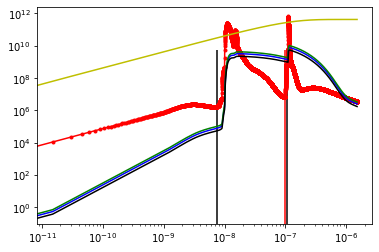

In [3]:
from scipy.interpolate import interp1d
inputs = np.loadtxt('power_density_point_vs_time.txt')
time = inputs[:,0]
jE = interp1d(time, inputs[:,1],bounds_error = False, fill_value = 'extrapolate')


def vt_sander(P,t,effic, relaxTime):
    rhs = -(effic*jE(t))/relaxTime - P/relaxTime
    return rhs

def vt_ashu(P, t, effic, relaxTime):
    rhs = (1-effic)*jE(t)/relaxTime - P/relaxTime
    return rhs

def vt_boeuf(P, t, effic, relaxTime):
    rhs = (effic)*jE(t)/relaxTime - P/relaxTime
    return rhs

t = np.linspace(0, time[-1], 100000)
P0 = 0.0
effic = 0.65
relaxTime = 0.1e-6 #The solution is inversely proportional to this value
P_sander = odeint(vt_sander, P0, t, args=(0.65, relaxTime))
P_ashu = odeint(vt_ashu, P0, t, args=(0.15, relaxTime))
P_boeuf = odeint(vt_boeuf, P0, t, args=(0.45, relaxTime))

plt.plot(t, jE(t),'r.-')
#P_vt /= -1e9 #Scaling for visualization
plt.plot(t,-P_sander,'b') ################----------------------------> Made positive
plt.plot(t, P_ashu, 'g')
plt.plot(t,P_boeuf,'k')
plt.plot(t, effic*1.0*max(inputs[:,1])*(1-np.exp(-t/relaxTime)),'y') #J.E constant assumption (Boeuf)
plt.vlines(7.5e-9, np.max(P_boeuf),0)
plt.vlines(107.5e-9, np.max(P_boeuf),0)
plt.vlines(relaxTime, np.max(P_boeuf),0,'r')

plt.xscale("log")
plt.yscale("log")

##### Vibrational-energy balance equation
- A fraction of the discharge energy goes into the 'vibrational reactions'
- These vibrational reactions slowly release this energy.
- The 'vibrational' energy increases/decreases according to the following balance equations (in Zero-D):

$$\frac{\mathrm{d} \epsilon_V}{\mathrm{dt}} = \eta_V \mathbf{j}\cdot \mathbf{E} - \frac{\epsilon_V - \epsilon_V(T_g)}{\tau_{VT}} \ \text{, where}$$

$$\epsilon_V(T_g) = \frac{n_{N_2} \delta E}{e^{(\delta ET_g/k_b)} - 1}, \ \delta E = 0.29eV$$

$$\tau_{VT} = (p_g/10^5)^{-1}*3.4\times10^{-12}e^{195\times T_g^{-1/3}}$$

In [11]:
pg = 1e5
Tg = 298
kb = 8.617e-5 #(eV)
dE = 0.29
n_N2 = 0.8*1e24
eV_to_Joule = 1.6e-19

eV_Tg = (n_N2*dE)/(np.exp(dE/(kb*Tg)) - 1)
t_vt = (3.4e-12*np.exp(195*Tg**(-1./3.)))*(pg/1e5)**(-1)
print(eV_Tg*eV_to_Joule, t_vt)

0.46231881596517826 16.23072036653784


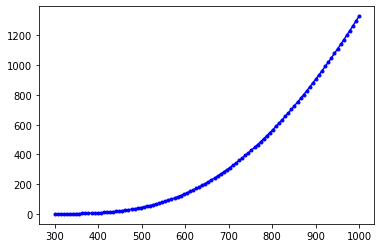

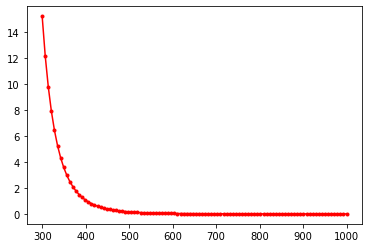

In [10]:
#Plot of the vibrational energy parameters vs gas temperature

pg = 1e5
kb = 8.617e-5 #(eV)
dE = 0.29 #(eV)
n_N2 = 0.8*1e24
eV_to_Joule = 1.6e-19
Tg  = np.linspace(300, 1000, 100)
plt.figure(1)
plt.plot(Tg, eV_to_Joule*(n_N2*dE)/(np.exp(dE/(kb*Tg)) - 1),'b.-')
plt.figure(2)
plt.plot(Tg, (3.4e-12*np.exp(195*Tg**(-1./3.)))*(pg/1e5)**(-1),'r.-')

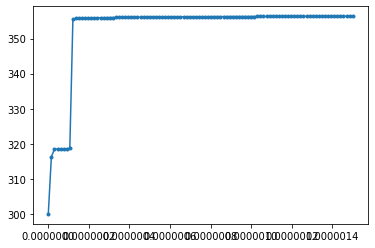

In [19]:
from scipy.interpolate import interp1d
inputs = np.loadtxt('power_density_point_vs_time.txt')
time = inputs[:,0]
jE = interp1d(time, inputs[:,1],bounds_error = False, fill_value = 'extrapolate')

#Temperature equation
mass_air = 28.8*1.67e-27
Cv = 0.718e-3 #(J/kg.K)
kb = 8.617e-5 #(eV)
eV_to_Joule = 1.6e-19
Pg = 1e5 #(Pa)
Tg = 300 #(K)
N = Pg/(kb*eV_to_Joule*Tg) #(m-3)
rho = mass_air*N #(This comes out to 1.16 kg/m3 as the density of air, which is accurate enough)
gamma = 1.4
R = 8.314

def heating1(T, t):
    rhs = (jE(t)*(gamma-1))/(gamma*R)
    return rhs

t = np.linspace(0, time[-1], 100)
T0 = 300
T_1 = odeint(heating1, T0, t)
plt.figure(1)
plt.plot(t,T_1,'.-') 
#plt.yscale("log")